In [1]:
using JuMP  
using Ipopt 
using Plots
using Plots.PlotMeasures

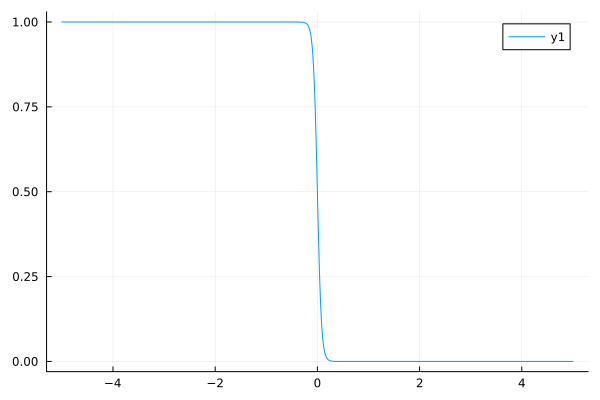

In [3]:
distance_squared(x, a) = x < a ? (a - x)^2 : 0 ;

#Moreau Yosida regularization

function MY_reg(x, k)
    return 1/(1+exp(-k*x))
end
f(x) = MY_reg(x, 25)
g(x) = 1 - f(x)
plot(g, -5, 5)

In [6]:
mutable struct Direct
    t; x1; x2; u ; 
end

In [7]:
function example(x0; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-6)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
    set_optimizer_attribute(sys,"max_iter",500)

    N  = nsteps     # Grid size

    @variables(sys, begin
        x1[1:N+1]          
        x2[1:N+1]          
     1 ≤ u[1:N+1] ≤ 5    # Control
    end)

    T   = 50.0    ;
    Δt  = T/N     ; 
    
    # Objective
    #@NLobjective(sys, Min, -b4[N+1]+(1/ϵ)*s33[N+1])
    @NLobjective(sys, Min, -x1[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]     == x0[1]
        con_x20, x2[1]     == x0[2]
       # con_x1f, x1[N+1]   == 1.


    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1],(1- f(x2[j]))*(x1[j]+u[j])    + (f(x2[j]))*7*x1[j])
    @NLexpression(sys, dx2[j = 1:N+1],(1- f(x2[j]))*(-2*x2[j]+u[j]) + (f(x2[j]))*(2*x2[j]+u[j]))
    

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
    end);

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u = value.(u)[:]

    t  = (0:N) * value.(Δt)


    return Direct(t, x1, x2, u)
    
end;

In [10]:
# Resolution
x0         = [-2, -2] ;
direct_sol = example(x0, nsteps=400);

In [ ]:
t  = direct_sol.t
x1 = direct_sol.x1
x2 = direct_sol.x2
u  = direct_sol.u

a  = plot(x1, x2,  xlabel = "x1", ylabel = "x2",  legend = false)
b  = plot(t, u,  xlabel = "t", ylabel = "u",  legend = false)

plot(a, b, layout = (2,2), size=(1200,800), left_margin=5mm)